<a href="https://colab.research.google.com/github/vachaconcu/Mineriadatos/blob/master/Edad_Resnet_v1_3_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import tarfile
from skimage import data
from os import remove
from skimage.color import rgb2gray
from numpy import load
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from sklearn.model_selection import train_test_split
from google.colab import files
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape,ZeroPadding2D,Activation,MaxPooling2D,Dropout
from keras.layers import BatchNormalization
from keras.models import Model
from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SpatialDropout2D
from matplotlib import pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
from numpy import load
import os
os.chdir('/content/drive/My Drive/Mineria/Train-Test 90%')

datos= load('/content/drive/My Drive/Mineria/Interna/datos/X_E_train.npz') ; x_train = datos['arr_0']
datos= load('/content/drive/My Drive/Mineria/Interna/datos/y_E_train_g.npz') ; y_train = datos['arr_0']
datos= load('/content/drive/My Drive/Mineria/Interna/datos/y_E_test_val_int_g.npz') ; y_test = datos['arr_0']
datos= load('/content/drive/My Drive/Mineria/Interna/datos/X_E_val_int.npz') ; x_test = datos['arr_0']
datos= load('/content/drive/My Drive/Mineria/Interna/datos/y_E_val_ext.npz') ; y_test2 = datos['arr_0']
datos= load('/content/drive/My Drive/Mineria/Interna/datos/y_E_test_val_ext_g.npz') ; x_test2 = datos['arr_0']

In [26]:
print('x_test =',x_test.shape)
print('x_train =',x_train.shape)
print('y_test =',y_test.shape)
print('y_train =',y_train.shape)
print('x_test =',x_test2.shape)
print('x_train =',y_test2.shape)

x_test = (1719, 200, 200, 3)
x_train = (6874, 200, 200, 3)
y_test = (1719, 20)
y_train = (6874, 20)
x_test = (2063, 20)
x_train = (2063, 101)


In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import numpy as np
import os

In [6]:
batch_size = 32 # orig paper trained all networks with batch_size=128
epochs = 200
#epochs = 10
data_augmentation = True
num_classes = 101
# subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter para sexo c: 
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# model version
# orig paper: version = 1 (ResNet v1), 
# improved ResNet: version = 2 (ResNet v2)
version = 1

# computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)
model_type

'ResNet20v1'

In [12]:
# input image dimensions.
input_shape = x_train.shape[1:]

#x_train = x_train.astype('float32') 
#x_test = x_test.astype('float32') 

# if subtract pixel mean is enabled 
# center the column-data around zero
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (6874, 200, 200, 3)
6874 train samples
1719 test samples
y_train shape: (6874, 101)


In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    Arguments:
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    Returns:
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
    
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v2(input_shape, depth, num_classes=2):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or 
    also known as bottleneck layer.
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, 
    the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, 
    while the number of filter maps is
    doubled. Within each stage, the layers have 
    the same number filters and the same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    Arguments:
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    Returns:
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 110 in [b])')
    # start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)
    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU
    # on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                # first layer and first stage
                if res_block == 0:  
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                # first layer but not first stage
                if res_block == 0:
                    # downsample
                    strides = 2 

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection
                # to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])

        num_filters_in = num_filters_out
# add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
def resnet_v1(input_shape, depth, num_classes=101):
    """ResNet Version 1 Model builder 

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved
    (downsampled) by a convolutional layer with strides=2, while 
    the number of filters is doubled. Within each stage, 
    the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx 
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    Arguments:
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    Returns:
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32)')
    # start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            # first layer but not first stack
            if stack > 0 and res_block == 0:
                # linear projection residual shortcut
                # connection to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model



In [0]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

In [31]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
plot_model(model, to_file="%s.png" % model_type, show_shapes=True)
print(model_type)

Learning rate:  0.001
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 200, 200, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 200, 200, 16) 64          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 200, 200, 16) 0           batch_normalization_19[0][0]     
______________________________________________________________________

In [32]:
# prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), './Modelos')
model_name = 'E_n3_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # this will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False)

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # fit the model on the batches generated by datagen.flow().
    history= model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, 
                        steps_per_epoch=len(x_train)//batch_size,
                        callbacks=callbacks)

Using real-time data augmentation.
Learning rate:  0.001
Epoch 1/200
214/214 [==============================] - ETA: 0s - loss: 4.4741 - accuracy: 0.0890
Epoch 00001: val_accuracy improved from -inf to 0.09308, saving model to /content/drive/My Drive/Mineria/Train-Test 90%/./Modelos/E_n3_ResNet20v1_model.001.h5
214/214 [==============================] - 77s 360ms/step - loss: 4.4741 - accuracy: 0.0890 - val_loss: 4.1993 - val_accuracy: 0.0931 - lr: 0.0010
Learning rate:  0.001
Epoch 2/200
214/214 [==============================] - ETA: 0s - loss: 4.1275 - accuracy: 0.1030
Epoch 00002: val_accuracy improved from 0.09308 to 0.11227, saving model to /content/drive/My Drive/Mineria/Train-Test 90%/./Modelos/E_n3_ResNet20v1_model.002.h5
214/214 [==============================] - 76s 353ms/step - loss: 4.1275 - accuracy: 0.1030 - val_loss: 4.0916 - val_accuracy: 0.1123 - lr: 0.0010
Learning rate:  0.001
Epoch 3/200
214/214 [==============================] - ETA: 0s - loss: 4.0184 - accuracy: 

In [0]:
import tensorflow as tf
import keras

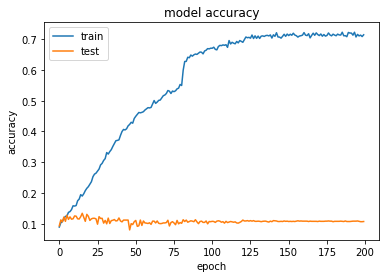

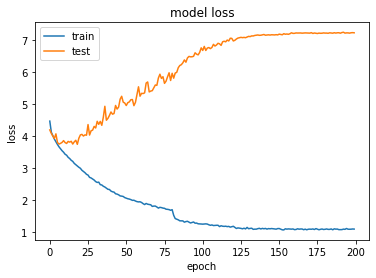

In [33]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
#using last check point
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

model = load_model("/content/drive/My Drive/Mineria/Train-Test 90%/Modelos/E_n3_ResNet20v1_model.016.h5")

In [34]:
# score trained model
scores = model.evaluate(x_test2,
                        y_test2,
                        batch_size=32,
                        verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 18.761594772338867
Test accuracy: 0.013572467491030693


In [0]:
prob=model.predict(x_test2)

In [0]:
r=[]
for i in range(y_test2.shape[0]):
  a = np.argmax(prob[i])
  if a==94: a=95
  if a==95: a=96
  if a==96: a=99
  if a==97: a=100
  if a==98: a=105
  if a==99: a=110
  if a==100: a=115
  if a==101: a=116
  r.append(a)

In [0]:
verdadero=[]
for i in range(y_test2.shape[0]):
  a = np.argmax(y_test2[i])
  if a==94: a=95
  if a==95: a=96
  if a==96: a=99
  if a==97: a=100
  if a==98: a=105
  if a==99: a=110
  if a==100: a=115
  if a==101: a=116
  verdadero.append(a)

for i in range(verdadero.shape)

In [12]:
print(r[50])
print(np.argmax(y_test2[50]))

44
64


In [0]:
bien= []
mal = []
for i in  range(y_test2.shape[0]):
  if verdadero[i]==r[i]: 
      bien.append(i)
  else: mal.append([verdadero[i],i,max(prob[i]),r[i]])

In [0]:
table=pd.DataFrame(mal)
table.columns=["y_test","i","prob_max","pred"]

In [0]:
desf= []
for i in range(table.i.shape[0]):
  desf.append(table.pred[i]-table.y_test[i])

In [39]:
len(bien)

29

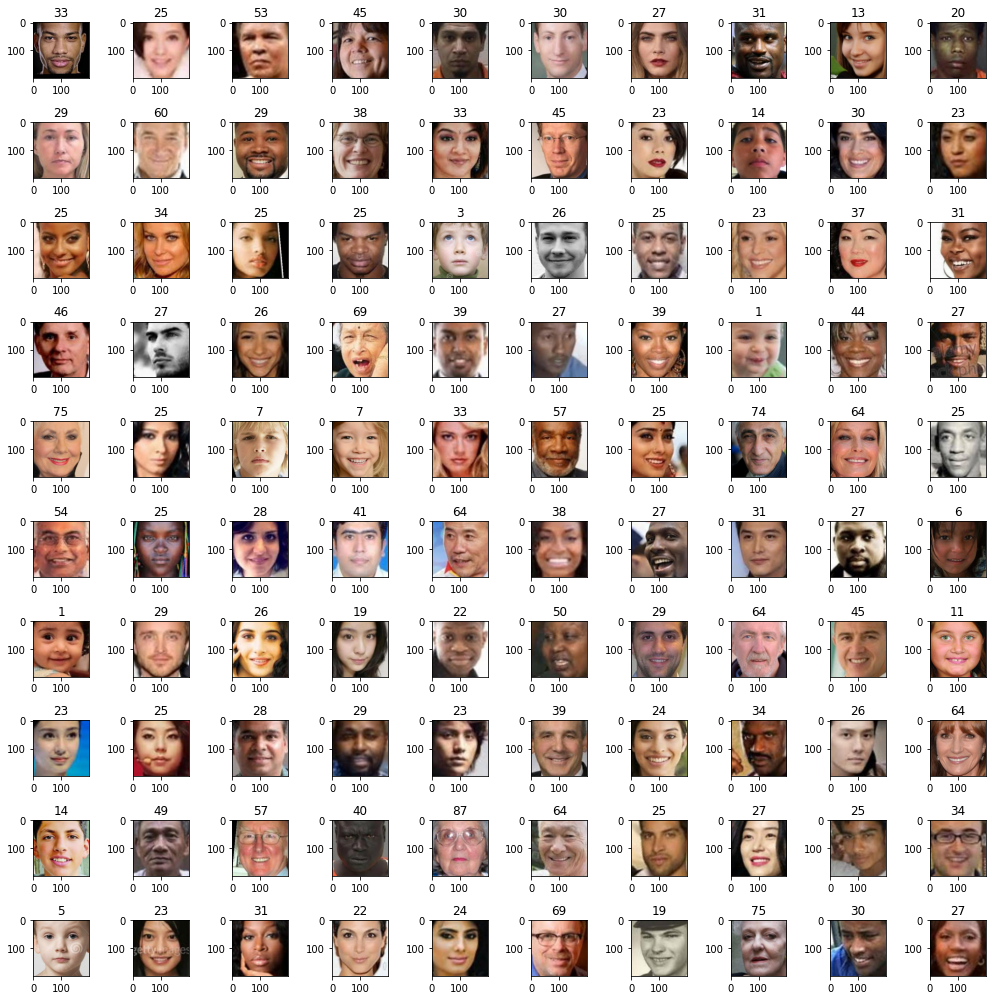

In [42]:
fig, axes = plt.subplots(10, 10, figsize=(14,14))
ax = axes.ravel()
w=0

# probabilidad de ser hombre 
for a in range(0,100):
  i = table.i[a]
  image = np.squeeze(x_test2[i])
  ax[w].imshow(image)
  ax[w].set_title(verdadero[i])
  w= w+1

fig.tight_layout()
plt.show()

In [0]:
print(y_test[10])
print(r[10])

image = np.squeeze(x_test[10])
plt.imshow(image)

In [0]:
y_test2_g=[]
for i in range(y_test2.shape[0]):
  a= np.argmax(y_test2[i])
  if a<=5: y_test2_g.append(1)
  if a>5 and a<=10: y_test2_g.append(1)
  if a>10 and a<=15: y_test2_g.append(2)
  if a>15 and a<=20: y_test2_g.append(3)
  if a>20 and a<=25: y_test2_g.append(4)
  if a>25 and a<=30: y_test2_g.append(5)
  if a>30 and a<=35: y_test2_g.append(6)
  if a>35 and a<=40: y_test2_g.append(7)
  if a>40 and a<=45: y_test2_g.append(8)
  if a>45 and a<=50: y_test2_g.append(9)
  if a>50 and a<=55: y_test2_g.append(10)
  if a>55 and a<=60: y_test2_g.append(11)
  if a>60 and a<=65: y_test2_g.append(12)
  if a>65 and a<=70: y_test2_g.append(13)
  if a>70 and a<=75: y_test2_g.append(14)
  if a>75 and a<=80: y_test2_g.append(15)
  if a>80 and a<=85: y_test2_g.append(16)
  if a>85 and a<=90: y_test2_g.append(17)
  if a>90 and a<=94: y_test2_g.append(18) 
  if a>94 and a<=97: y_test2_g.append(19)
  if a>97: y_test2_g.append(20)

In [0]:
y_test_g=[]
for i in range(y_test.shape[0]):
  a= np.argmax(y_test[i])
  if a<=5: y_test_g.append(1)
  if a>5 and a<=10: y_test_g.append(1)
  if a>10 and a<=15: y_test_g.append(2)
  if a>15 and a<=20: y_test_g.append(3)
  if a>20 and a<=25: y_test_g.append(4)
  if a>25 and a<=30: y_test_g.append(5)
  if a>30 and a<=35: y_test_g.append(6)
  if a>35 and a<=40: y_test_g.append(7)
  if a>40 and a<=45: y_test_g.append(8)
  if a>45 and a<=50: y_test_g.append(9)
  if a>50 and a<=55: y_test_g.append(10)
  if a>55 and a<=60: y_test_g.append(11)
  if a>60 and a<=65: y_test_g.append(12)
  if a>65 and a<=70: y_test_g.append(13)
  if a>70 and a<=75: y_test_g.append(14)
  if a>75 and a<=80: y_test_g.append(15)
  if a>80 and a<=85: y_test_g.append(16)
  if a>85 and a<=90: y_test_g.append(17)
  if a>90 and a<=94: y_test_g.append(18) 
  if a>94 and a<=97: y_test_g.append(19)
  if a>97: y_test_g.append(20)

In [0]:
y_train_g=[]
for i in range(y_train.shape[0]):
  a= np.argmax(y_train[i])
  if a<=5: y_train_g.append(1)
  if a>5 and a<=10: y_train_g.append(1)
  if a>10 and a<=15: y_train_g.append(2)
  if a>15 and a<=20: y_train_g.append(3)
  if a>20 and a<=25: y_train_g.append(4)
  if a>25 and a<=30: y_train_g.append(5)
  if a>30 and a<=35: y_train_g.append(6)
  if a>35 and a<=40: y_train_g.append(7)
  if a>40 and a<=45: y_train_g.append(8)
  if a>45 and a<=50: y_train_g.append(9)
  if a>50 and a<=55: y_train_g.append(10)
  if a>55 and a<=60: y_train_g.append(11)
  if a>60 and a<=65: y_train_g.append(12)
  if a>65 and a<=70: y_train_g.append(13)
  if a>70 and a<=75: y_train_g.append(14)
  if a>75 and a<=80: y_train_g.append(15)
  if a>80 and a<=85: y_train_g.append(16)
  if a>85 and a<=90: y_train_g.append(17)
  if a>90 and a<=94: y_train_g.append(18) 
  if a>94 and a<=97: y_train_g.append(19)
  if a>97: y_train_g.append(20)

In [0]:
y = np.concatenate((y_test_g,y_test2_g))
y=pd.get_dummies(y)
y_train_g=pd.get_dummies(y_train_g)

In [0]:
y_test_g=y[0:len(y_test_g)]
y_test2_g=y[len(y_test_g):len(y)]

In [19]:
print(y_test.shape)
print(y_test_g.shape)
print(y_test2.shape)
print(y_test2_g.shape)
print(y_train.shape)
print(y_train_g.shape)

(1719, 101)
(1719, 20)
(2063, 101)
(2063, 20)
(6874, 101)
(6874, 20)


In [0]:
from numpy import asarray
from numpy import savez_compressed
savez_compressed('/content/drive/My Drive/Mineria/Interna/datos/y_E_train_g.npz',y_train_g)
savez_compressed('/content/drive/My Drive/Mineria/Interna/datos/y_E_test_val_ext_g.npz',y_test2_g)
savez_compressed('/content/drive/My Drive/Mineria/Interna/datos/y_E_test_val_int_g.npz',y_test_g)